# 1. PLUTO HD example in 2D, spherical coordinates

In [1]:
import numpy as np
import astropy.units as u #To keep track of units
import matplotlib.pyplot as plt #For plotting

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#Constants
k_b = 1.38*10**-23*(u.joule*u.K**-1)
mu = 0.6
mH = 1.67*10**-27*u.kg # mass of hydrogen atom
gamma = 5.0/3.0 #adiabatic index

In [3]:
#We begin by defining some useful functions:

def tempToSoundSpeed(mu,TempInEv,gamma):
    "Converts a temperature to a sound speed for a given mu, where mu is the average particle molecular mass?"
    soundspeed = np.sqrt((TempInEv*gamma)/(mu*mH)).to(u.m/u.second)
    return soundspeed

def jetSolidAngle(theta_jet):
    "Calculates the solid angle of a jet given a constant opening angle"
    Omega = 2.0*np.pi*(1-np.cos(np.deg2rad(theta_jet)))
    return Omega

def CalcL1(Q0, rho, vjet):
    L1 = 2.0*np.sqrt(2.0)*np.sqrt(Q0/(rho*vjet**3)).to(u.parsec)
    return L1

def CalcL2(Q0,rho,cs):
    L2 = np.sqrt(Q0/(rho*cs**3)).to(u.kiloparsec)
    return L2

def timeUnit(lengthUnit,velocityUnit):
    tau = (lengthUnit.to(u.m)/velocityUnit.to(u.m/u.second)).to(u.year)
    return tau

def initDensity(n,mu):
    "Calculated initial density of a profile given a number density n, and a mean mass per particle $\mu$"
    rho_0 = (n*mu*mH).to(u.kg/u.m**3)
    return rho_0

In [4]:
#Simulation variables

#Here we define the values that will need to be coded into the init.c file.
Mach = 25.0
theta_jet = 15.0*u.deg
Omega_jet = jetSolidAngle(theta_jet)
clusterTemp = 2000*u.eV
cs = tempToSoundSpeed(mu,clusterTemp,gamma)
c = 3*(10**8)*(u.m/u.second)
n = (3*10**4)*u.m**-3 #value from HK13, number density of particles per unit volume

print 'cs = ' + str(cs.to(u.km/u.second))
#Define set power
Q_0 = (10**38)*u.Watt
  
#So our variables are
v_jet = Mach*cs
rho_0 = initDensity(n,mu)
P = ((cs**2*rho_0)/gamma).to(u.pascal)

print 'rho_0 = ' + str(rho_0)

cs = 730.063606312 km / s
rho_0 = 3.006e-23 kg / m3


The length normalisation unit is defined as L1. A function CalcL1 has already been defined, and takes inputs Q, $\rho_0$ and v$_{jet}$. This will in turn allow for the calculation of the simulation time unit using the timeUnit function.

In [5]:
L1 = CalcL1(Q_0,rho_0,v_jet)
print 'L1 = ' + str(L1.to(u.kpc)) #Convert to kpc to get a more appropriate value
tau = timeUnit(L1,cs).to(u.Myr) #Convert to Myr to get a more appropriate value
print 'tau = ' + str(tau)

#And the jet is likely to propagate to a distance of L2
L2 = CalcL2(Q_0,rho_0,cs)
print 'L2 = ' + str(L2)
print (L2/L1).si
tstop = 10
jetAge = tstop*tau
print 'Jet age = ' + str(jetAge)

L1 = 2.14411906291 kpc
tau = 2.87167162413 Myr
L2 = 94.7575705659 kpc
44.1941738242
Jet age = 28.7167162413 Myr


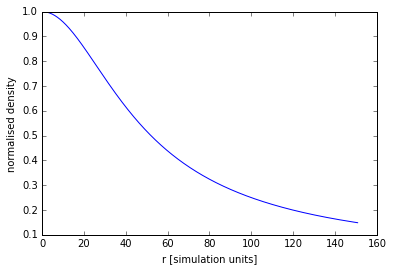

In [6]:
#Let us now assume that the density declines with radius as modelled by an isothermal King Profile
#Using the same cluster core radius as Hardcastle & Krause 2013
rc = 40
beta = 0.35
r = np.arange(0,151,0.2)
rho = rho_0*(1 + (r/rc)**2)**((-3/2)*beta)
rho_norm = (1 + (r/rc)**2)**((-3/2)*beta) #Letting rho_0 = 1 in simulation units

plt.figure()
plt.plot(r,rho_norm)
plt.xlabel('r [simulation units]')
plt.ylabel('normalised density')
plt.show()

### In summary:
#### Unit type - Physical unit per code/simulation unit
- Length unit = L1 = 2.14kpc
- Time unit = tau = 2.87Myr
- density unit = $\rho_0$ = 3.006e-23 kg / m3


The variables and values defined here will be used in the discussion in Section 2.

# 2. Imaging the simulation

The methods used to image the PLUTO simulation are discussed in Section 1.2.3 of the accompanying latex document.

Reading Data file : /Users/Jonathan/Desktop/Projects/PLUTO_process_writeup/SECTION2_NOTEBOOK/data.0010.dbl


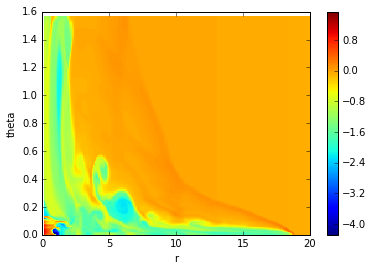

In [7]:
#Import the simulation and image it
import pyPLUTO as pp
import matplotlib.pyplot as plt
import numpy as np
#need to fix files
run_dir = '/Users/Jonathan/Desktop/Projects/PLUTO_process_writeup/SECTION2_NOTEBOOK/' #This must be your working directory
l = 10 #get the file number to plot
ns = 'rho'

curObject = pp.pload(l,w_dir=run_dir) #use pload to get the PLUTO object
globalVar = getattr(curObject,ns).T #as ns = 'rho', get the density grid

#Set up (R,Theta) grid
R, Theta = np.meshgrid(curObject.x1, curObject.x2)
#Theta = Theta - np.pi/2

plt.pcolormesh(R,Theta,np.log10(globalVar),shading='flat')
plt.xlabel('r')
plt.ylabel('theta')
cb = plt.colorbar()
plt.show()

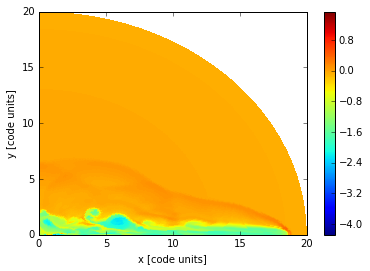

In [8]:
# convert grid to cartesian
X1 = R * np.cos(Theta)
X2 = R * np.sin(Theta)

plt.pcolormesh(X1,X2,np.log10(globalVar),shading='flat')
plt.xlabel('x [code units]')
plt.ylabel('y [code units]')

cb = plt.colorbar()
plt.show()

It is better practice to write these into functions. These functions can be added to over time in order to customise your plots. These functions are written using the code used above.

In [9]:
def getData(l,ns,w_dir):
    """
    Function takes input of dbl number, the variable (as a string, eg 'rho')
    and the directory that your data is in (again, a string with a / on the end)
    
    The output variables are a grid of cartesian coordinates, and the 2D map of your specified variable (ns)
    """
    
    import pyPLUTO as pp
    curObject = pp.pload(l,w_dir)
    globalVar = getattr(curObject,ns).T
    R, Theta = np.meshgrid(curObject.x1, curObject.x2)
    #To point jet up, set Theta = Theta - pi/2, and np.sin(-Theta)
    X1 = R * np.cos(Theta)
    X2 = R * np.sin(Theta)        
    return X1,X2,globalVar

def plotData(X1,X2,globalVar):
    """
    Plots an input parameters, ns, over the (X1,X2) grid.
    The axis_labels is a list of 3 strings. x axis, y axis, colorbar respectively. 
    """
    plt.pcolormesh(X1,X2,globalVar,shading='flat')
    plt.xlabel('x [code units]')
    plt.ylabel('y [code units]')
    cb = plt.colorbar()
    plt.show()

Reading Data file : /Users/Jonathan/Desktop/Projects/PLUTO_process_writeup/SECTION2_NOTEBOOK/data.0010.dbl


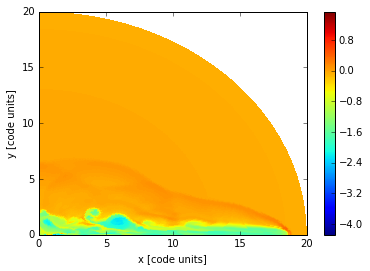

In [10]:
#The data can now simply be plotted using

X1, X2, globalVar = getData(l,ns,run_dir)
plotData(X1,X2,np.log10(globalVar))